In [1]:
import matplotlib.pyplot as plt
# follow the tutorial at http://docs.lightkurve.org/tutorials/03-making-custom-apertures.html
from lightkurve import search_targetpixelfile
# get the pixel data for all quarters
pixelfile = search_targetpixelfile('KIC 7098049').download_all();

In [2]:
pixelfile

TargetPixelFileCollection of 13 objects:
	7098049 (13 KeplerTargetPixelFiles) Quarters: 1,2,3,4,6,7,8,10,11,12,14,15,16

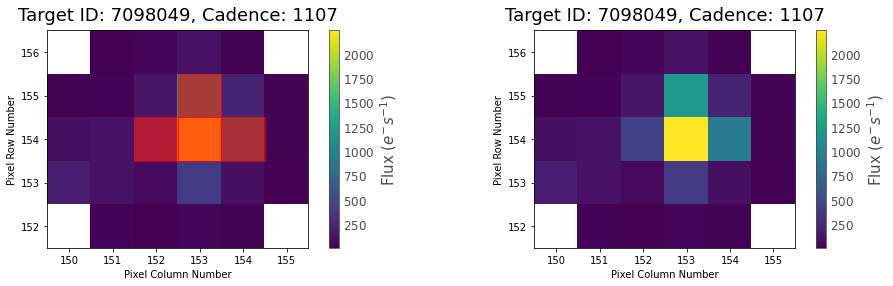

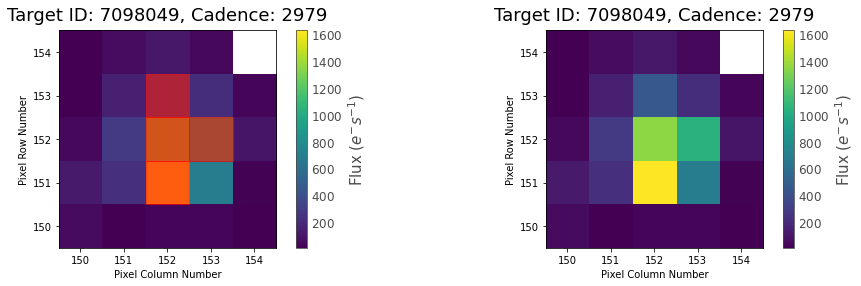

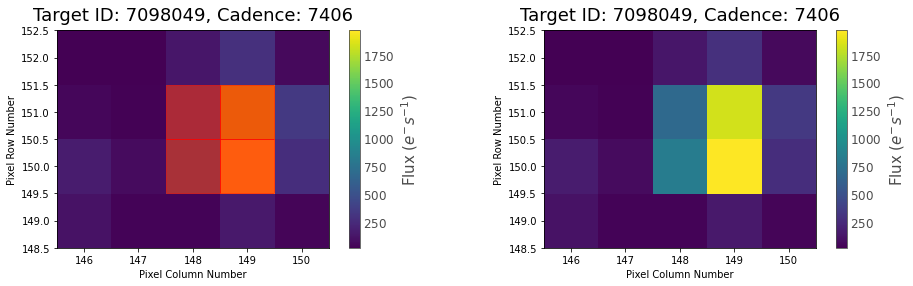

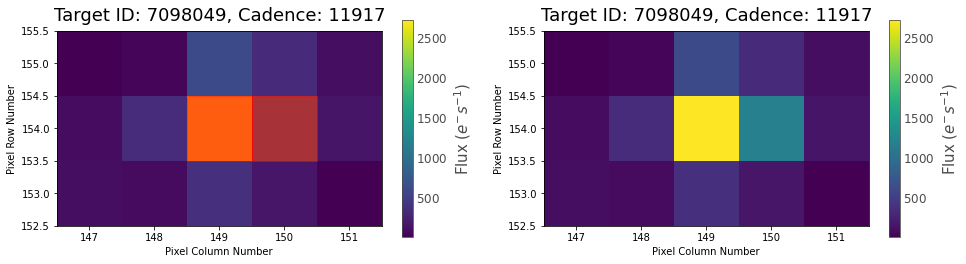

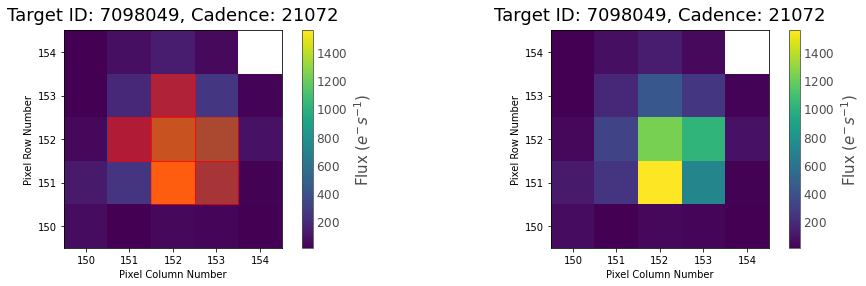

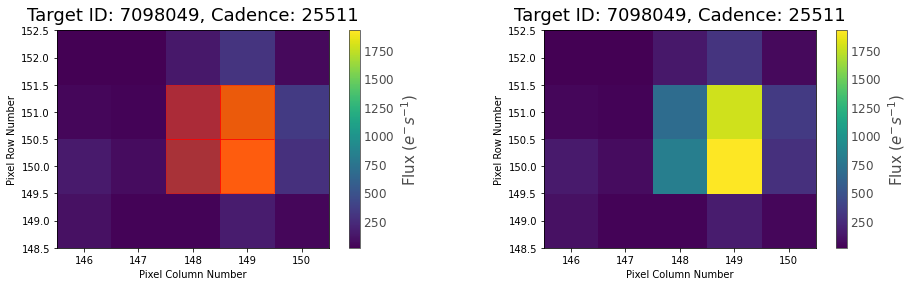

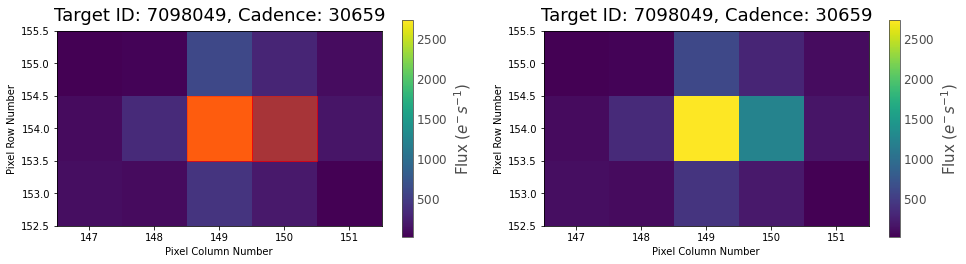

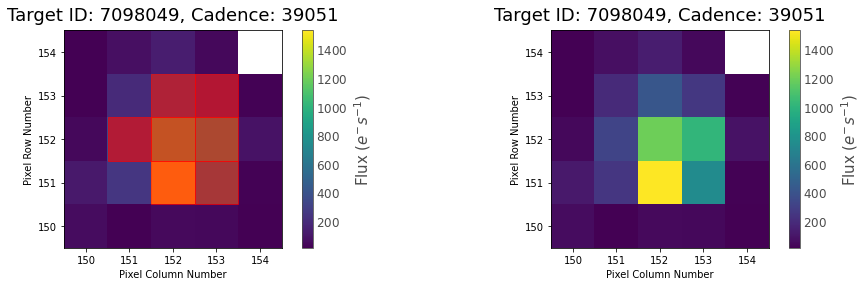

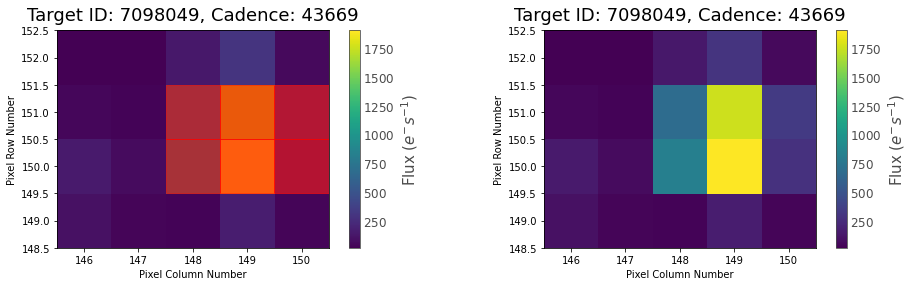

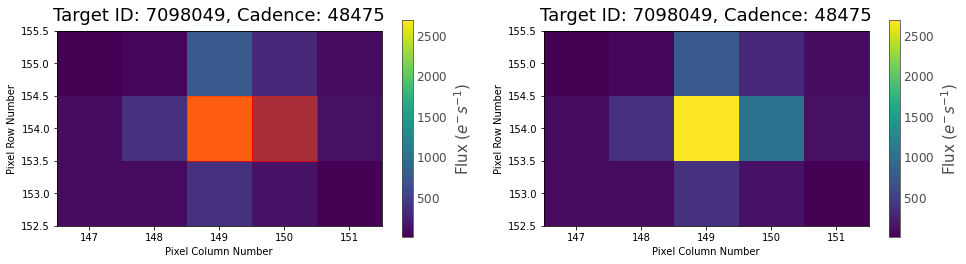

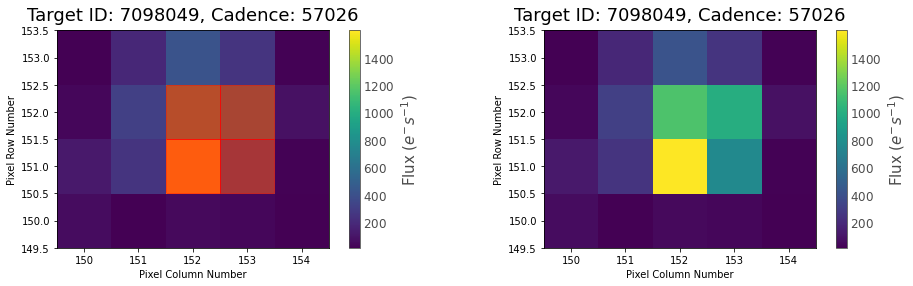

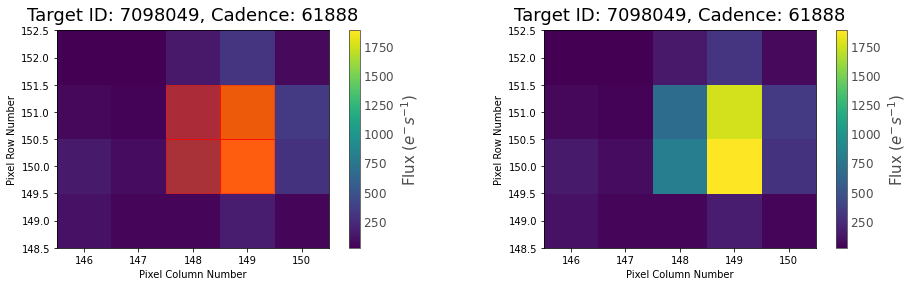

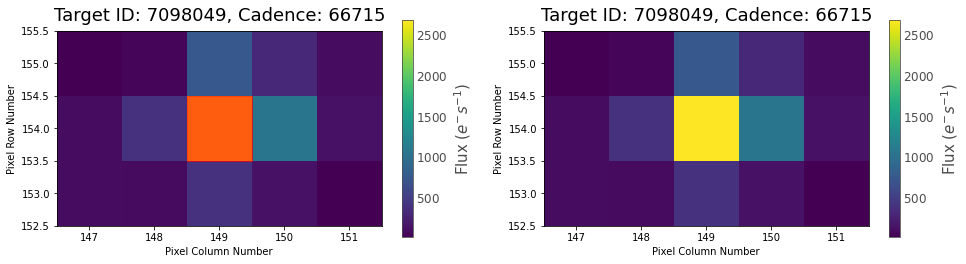

In [3]:
# Check the apertures for quarters where there is data

for quarter in range(len(pixelfile)):
    fig = plt.figure(figsize=plt.figaspect(0.25));
    ax = fig.add_subplot(1, 2, 1)
    pixelfile[quarter].plot(ax=ax, frame=2, aperture_mask=pixelfile[quarter].pipeline_mask, mask_color='red');

    ax = fig.add_subplot(1, 2, 2)
    pixelfile[quarter].plot(ax=ax, frame=2);



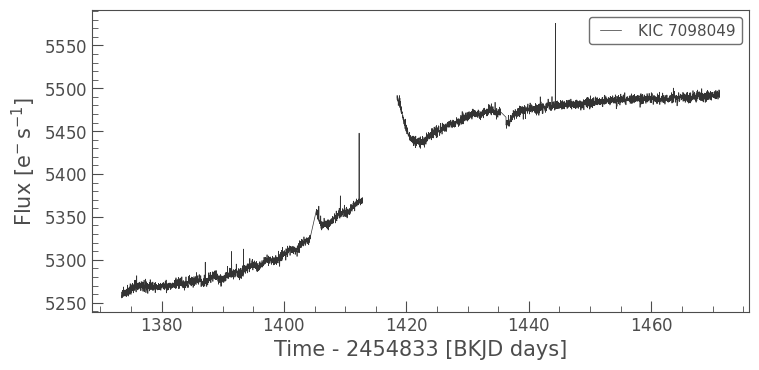

In [4]:
# plot the light curve of a sample quarter
quarter = 11

# make the light curve from the pixel file
lc = pixelfile[quarter].to_lightcurve();
lc.plot();


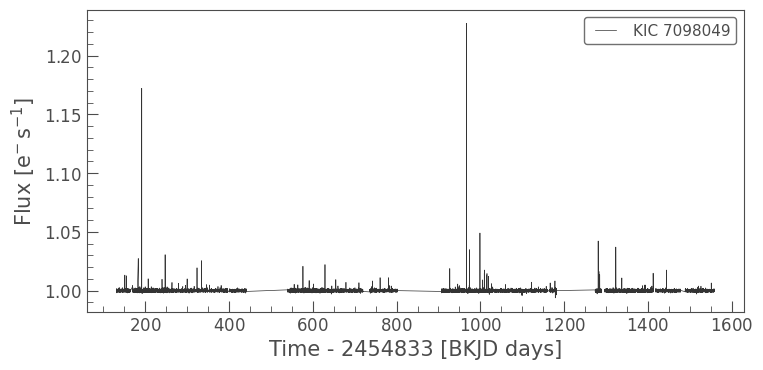

In [5]:
# make light curves out of the pixel data using all quarters, detrended by .flatten() so they line up together
lc = pixelfile[0].to_lightcurve().flatten();
for pf in pixelfile[1:]:
    lc = lc.append(pf.to_lightcurve().flatten())
lc.remove_nans().remove_outliers()

lc.plot();

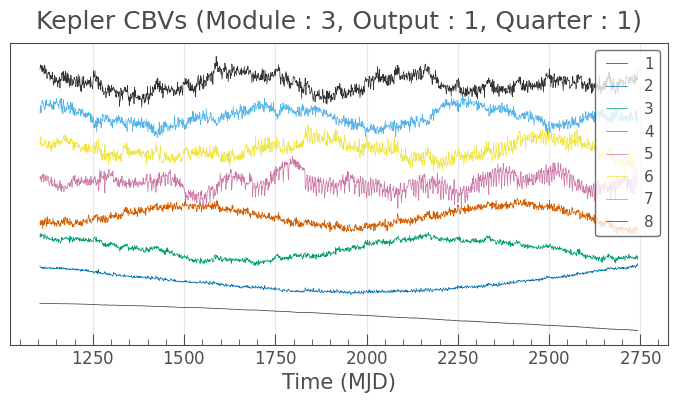

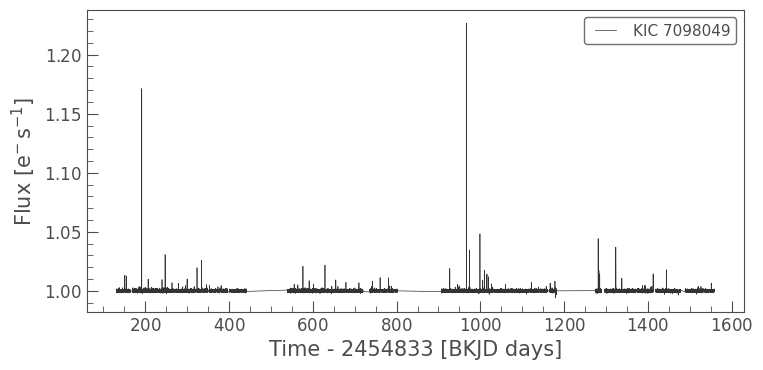

In [6]:
# remove signals that are common to all nearby stars using the Cotrending Basis Vectors (CBVs)

from lightkurve.correctors import KeplerCBVCorrector

# look at example CBVs to make sure they are reasonable
KeplerCBVCorrector(lc).plot_cbvs([1,2,3,4,5,6,7,8]);
# make corrected light curves out of the pixel data using all quarters, detrended by .flatten()
# the .correct() function removes signals correlated with the CBVs
temp_lc = pixelfile[0].to_lightcurve();
corr_lc =  KeplerCBVCorrector(temp_lc).correct(cbvs=[1,2,3,4,5]).flatten()
for pf in pixelfile[1:]:
    temp_lc = pf.to_lightcurve()
    corr_lc = corr_lc.append(KeplerCBVCorrector(temp_lc).correct(cbvs=[1,2,3,4,5]).flatten())
corr_lc.remove_nans().remove_outliers()
corr_lc.plot();

Text(0.5, 1.0, 'Uncorrected Flux')

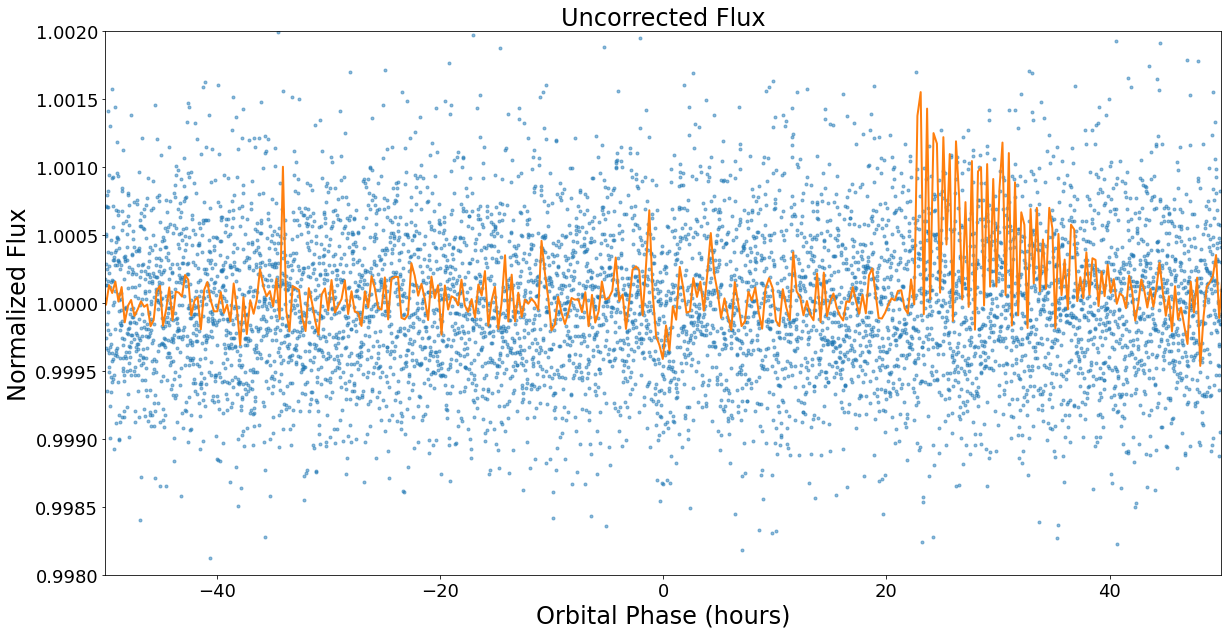

In [7]:
# plot the folded light curve by period and epoch
period = 31.0655819;
epoch = 151.711;

xRangeHours = 50
yRange = 2e-3
binFactor = 20
periodHours = period*24

foldedLc = lc.fold(period = period, t0=epoch)
foldedBinnedLc = lc.fold(period = period, t0=epoch).bin(binFactor)

plt.figure(figsize=(20,10))
plt.plot(foldedLc.phase*periodHours, foldedLc.flux, '.', alpha=0.5)
plt.plot(foldedBinnedLc.phase*periodHours, foldedBinnedLc.flux, lw=2)
plt.xlim(-xRangeHours, xRangeHours)
plt.ylim(1-yRange, 1+yRange);
plt.tick_params(labelsize = 18)
plt.xlabel("Orbital Phase (hours)", fontsize = 24)
plt.ylabel("Normalized Flux", fontsize = 24)
plt.title("Uncorrected Flux", fontsize = 24)


Text(0.5, 1.0, 'Corrected Flux')

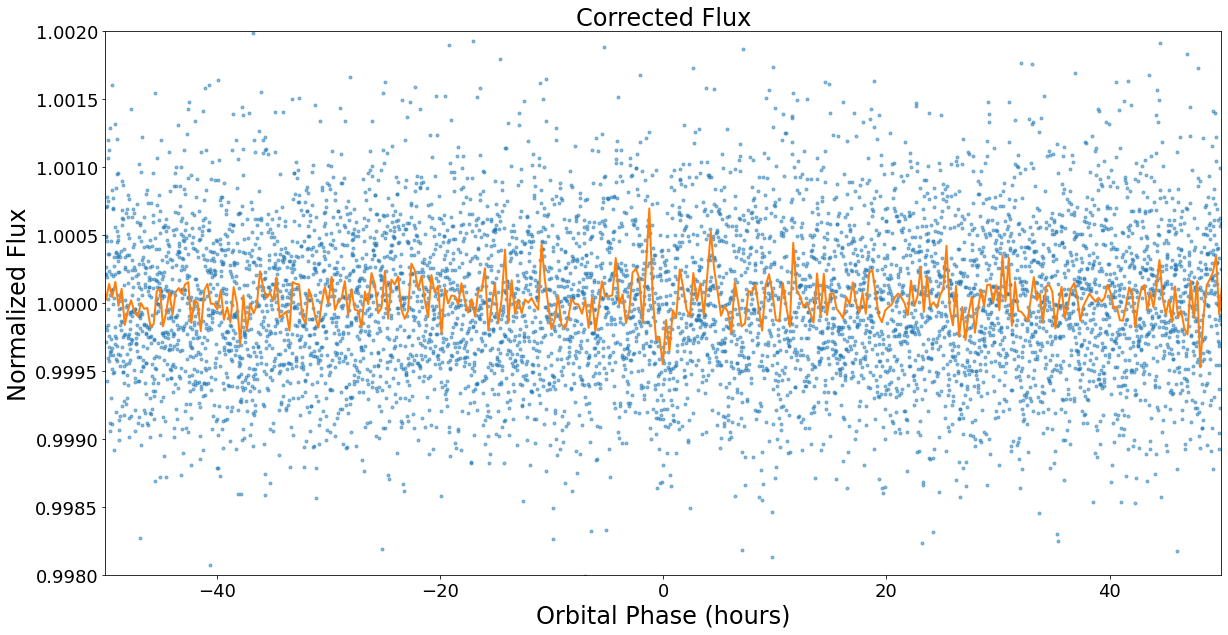

In [8]:
foldedCorrectedLc = corr_lc.fold(period = period, t0=epoch)
foldedBinnedCorrectedLc = corr_lc.fold(period = period, t0=epoch).bin(binFactor).remove_outliers()

plt.figure(figsize=(20,10))
plt.plot(foldedCorrectedLc.phase*periodHours, foldedCorrectedLc.flux, '.', alpha=0.5)
plt.plot(foldedBinnedCorrectedLc.phase*periodHours, foldedBinnedCorrectedLc.flux, lw=2)
plt.xlim(-xRangeHours, xRangeHours)
plt.ylim(1-yRange, 1+yRange);
plt.tick_params(labelsize = 18)
plt.xlabel("Orbital Phase (hours)", fontsize = 24)
plt.ylabel("Normalized Flux", fontsize = 24)
plt.title("Corrected Flux", fontsize = 24)
